# Contact Prediction Examples

This example shows contact prediction with the ESM-1b and MSA Transformer models. Contact prediction is based on a logistic regression over the model's attention maps. This methodology is based on our ICLR 2021 paper, "Transformer protein language models are unsupervised structure learners." (https://www.biorxiv.org/content/10.1101/2020.12.15.422761v1).

In [33]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string

In [2]:
torch.set_grad_enabled(False)

## Data Loading

This sets up some sequence loading utilities for ESM-1b (`read_sequence`) and the MSA Transformer (`read_msa`).

In [37]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

## Run ESM-1b Contact Prediction

In [34]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [64]:
esm1b_data = [
    read_sequence("1a3a_1_A.a3m"),
    read_sequence("5ahw_1_A.a3m"),
    read_sequence("1xcr_1_A.a3m"),
]

In [65]:
esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
esm1b_batch_tokens = esm1b_batch_tokens.cuda()
print(esm1b_batch_tokens.size(), esm1b_batch_tokens.dtype)  # Should be a 2D tensor with dtype torch.int64.

torch.Size([3, 315]) torch.int64


In [66]:
%%time
esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()

CPU times: user 197 ms, sys: 12 ms, total: 209 ms
Wall time: 255 ms


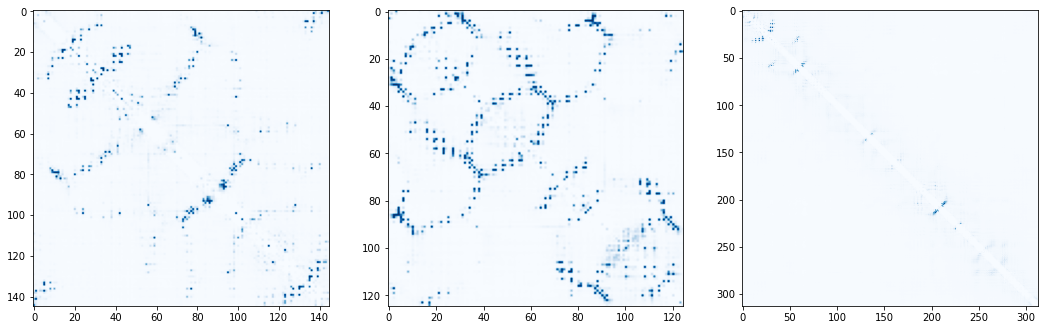

In [67]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, sequence in zip(axes, esm1b_contacts, esm1b_batch_strs):
    seqlen = len(sequence)
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()

## Run MSA Transformer Contact Prediction

In [51]:
msa_transformer, msa_alphabet = esm.pretrained.esm_msa1_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_batch_converter = msa_alphabet.get_batch_converter()

In [72]:
msa_data = [
    read_msa("1a3a_1_A.a3m", 64),
    read_msa("5ahw_1_A.a3m", 64),
    read_msa("1xcr_1_A.a3m", 64),
]
msa_batch_labels, msa_batch_strs, msa_batch_tokens = msa_batch_converter(msa_data)
msa_batch_tokens = msa_batch_tokens.cuda()
print(msa_batch_tokens.size(), msa_batch_tokens.dtype)  # Should be a 3D tensor with dtype torch.int64.

torch.Size([3, 64, 314]) torch.int64


In [73]:
%%time
msa_contacts = msa_transformer.predict_contacts(msa_batch_tokens).cpu()

CPU times: user 2.07 s, sys: 161 ms, total: 2.24 s
Wall time: 2.26 s


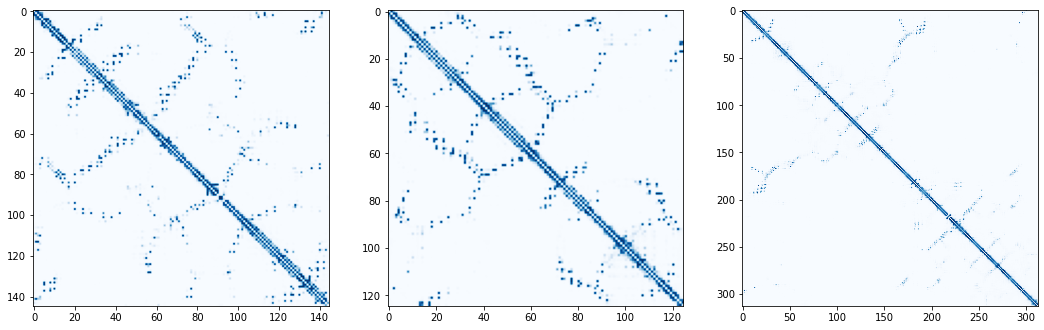

In [74]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, contact, msa in zip(axes, msa_contacts, msa_batch_strs):
    seqlen = len(msa[0])
    ax.imshow(contact[:seqlen, :seqlen], cmap="Blues")
plt.show()